# Training file for UpscaleNN

## Imports

In [1]:
import src.nntools as nt
from src.CarlaDataset import CarlaDatasetPatch
from src.PytorchUtil import PytorchUtil as torchUtil

from src.UpscaleNN import UpscaleNN

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()


if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

print(device)

cuda


# Utility function

In [2]:
class SuperResolutionStatsManager(nt.StatsManager):
    def __init__(self):
        super(SuperResolutionStatsManager, self).__init__()

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.running_psnr = 0
        self.running_ssim = 0

    def accumulate(self, loss, x, y, d):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d)
        # Updating `self.running_psnr`
        d_numpy = d.detach().to('cpu').numpy()
        y_numpy = y.detach().to('cpu').numpy()

        self.running_psnr += metrics.peak_signal_noise_ratio(d_numpy, y_numpy)

        current_ssim = 0

        for i in range(d_numpy.shape[0]):
            d_numpy_temp = np.moveaxis(d_numpy[i], [0, 1, 2], [2, 0, 1])
            y_numpy_temp = np.moveaxis(y_numpy[i], [0, 1, 2], [2, 0, 1])

            value_range = max(d_numpy_temp.max(), y_numpy_temp.max()) - min(d_numpy_temp.min(), y_numpy_temp.min())
            
            current_ssim += metrics.structural_similarity(d_numpy_temp, y_numpy_temp, win_size=7, data_range=value_range, multichannel=True, channel_axis=2)
        
        self.running_ssim += current_ssim / d_numpy.shape[0]

    def summarize(self):
        loss = super(SuperResolutionStatsManager, self).summarize()
        psnr = self.running_psnr / (self.number_update+1e-9 )
        ssim = self.running_ssim / (self.number_update+1e-9 )
        return {'loss': loss, 'psnr': psnr, "ssim": ssim}

def criterion(y, d):
    return F.mse_loss(y, d)

#show image
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    # ax.axis('off')
    return h

## Data loader

In [3]:
new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import your datasetclass

PATCH_SIZE = 32

full_train_dataset = CarlaDatasetPatch("1920x1080", "960x540", "train", transforms=train_transform, download=True, patch_size=PATCH_SIZE)
full_test_dataset = CarlaDatasetPatch("1920x1080", "960x540", "test", transforms=train_transform, download=True, patch_size=PATCH_SIZE)

train_dataset_patched = CarlaDatasetPatch("1920x1080", "960x540", "train", transforms=train_transform, download=True, patch_size=PATCH_SIZE)
test_dataset_patched = CarlaDatasetPatch("1920x1080", "960x540", "test", transforms=train_transform, download=True, patch_size=PATCH_SIZE)

SUBSET_SIZE = 20000
if len(train_dataset_patched) > SUBSET_SIZE:
    train_dataset_patched.limit_dataset(SUBSET_SIZE)

if len(test_dataset_patched) > SUBSET_SIZE * 0.2:
    test_dataset_patched.limit_dataset(int(SUBSET_SIZE * 0.2))

print("Size of sub train dataset", len(train_dataset_patched))
print("Size of sub test dataset", len(test_dataset_patched))

Dataset already present
Dataset already present
Dataset already present
Dataset already present
Size of sub train dataset 4000
Size of sub test dataset 800


torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])


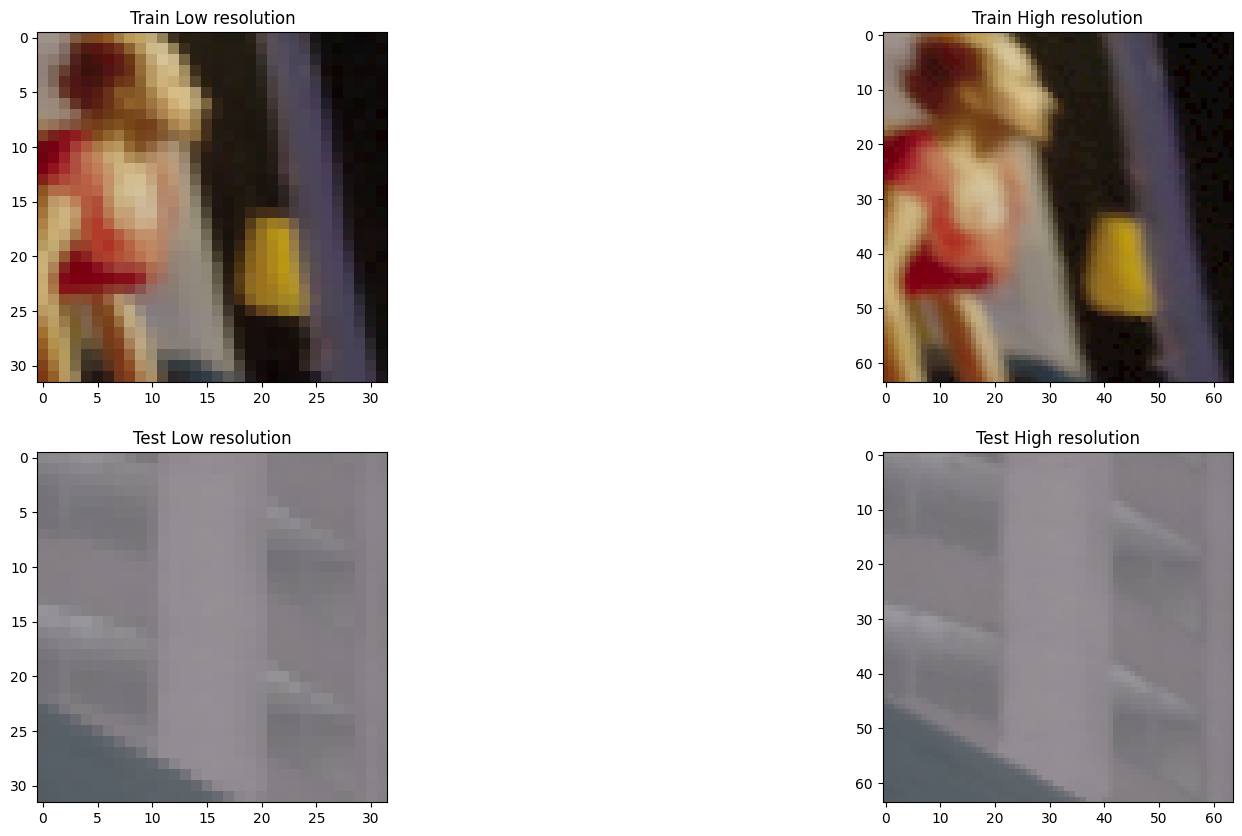

In [5]:
# Show one full image for both train and test
example1_low, example1_high = full_train_dataset[0]
example2_low, example2_high = full_test_dataset[0]

example1_low_image = torchUtil.tensor_to_image(example1_low)
example1_high_image = torchUtil.tensor_to_image(example1_high)

example2_low_image = torchUtil.tensor_to_image(example2_low)
example2_high_image = torchUtil.tensor_to_image(example2_high)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].imshow(example1_low_image)
ax[0, 0].set_title("Train Low resolution")
ax[0, 1].imshow(example1_high_image)
ax[0, 1].set_title("Train High resolution")
ax[1, 0].imshow(example2_low_image)
ax[1, 0].set_title("Test Low resolution")
ax[1, 1].imshow(example2_high_image)
ax[1, 1].set_title("Test High resolution")

plt.show()

torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])


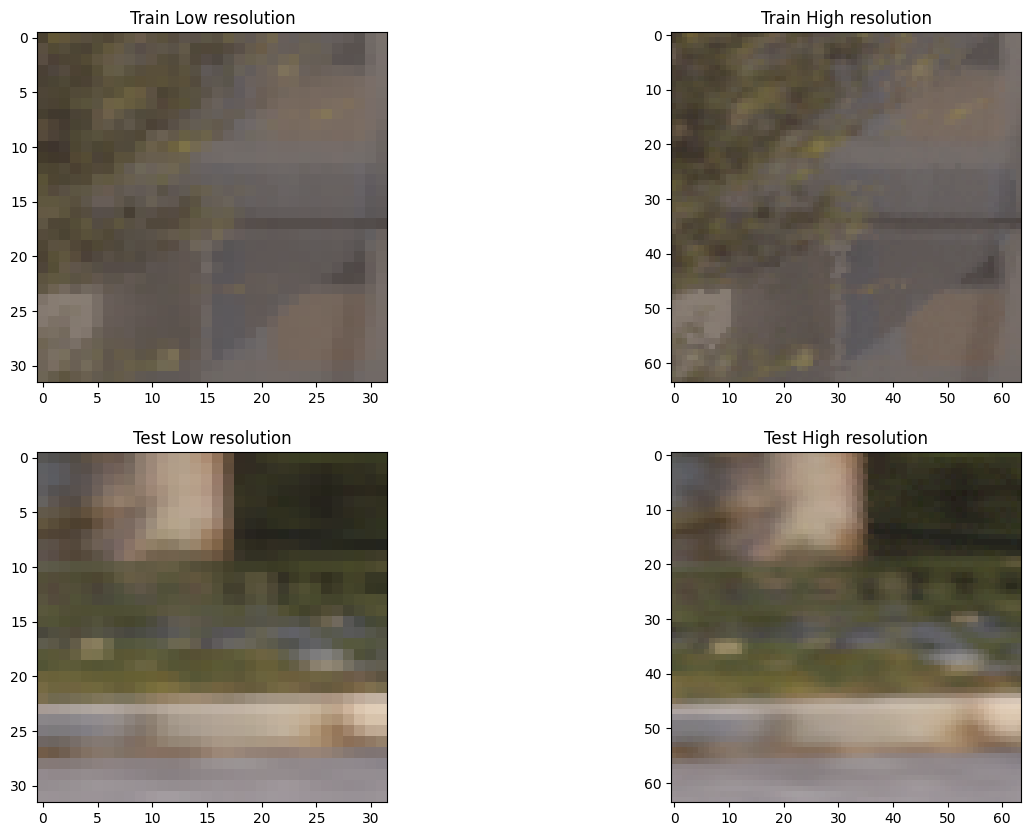

In [6]:
# Do the same for the patched dataset
example1_low, example1_high = train_dataset_patched[0]
example2_low, example2_high = test_dataset_patched[0]

example1_low_image = torchUtil.tensor_to_image(example1_low)
example1_high_image = torchUtil.tensor_to_image(example1_high)

example2_low_image = torchUtil.tensor_to_image(example2_low)
example2_high_image = torchUtil.tensor_to_image(example2_high)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].imshow(example1_low_image)
ax[0, 0].set_title("Train Low resolution")
ax[0, 1].imshow(example1_high_image)
ax[0, 1].set_title("Train High resolution")
ax[1, 0].imshow(example2_low_image)
ax[1, 0].set_title("Test Low resolution")
ax[1, 1].imshow(example2_high_image)
ax[1, 1].set_title("Test High resolution")

plt.show()

In [7]:
# Plot for the the predicted image, low resolution image and high resolution image in first row
# plot Plot the loss, psnr and ssim curves in the second row
def plot_images_and_metrics(exp, fig, axes, dataset, index): ##Only to use when perform_validation_during_training == True
    low_res, high_res = dataset[index]

    with torch.no_grad():
        predicted_res = exp.net(low_res.to(device))[0]

    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    axes[1][2].clear()

    low_res_image = torchUtil.tensor_to_image(low_res)
    high_res_image = torchUtil.tensor_to_image(high_res)
    predicted_res_image = torchUtil.tensor_to_image(predicted_res)

    axes[0][0].set_title(f'Low res: {low_res_image.shape}')
    axes[0][1].set_title(f'High res: {high_res_image.shape}')
    axes[0][2].set_title(f'Predicted res: {predicted_res_image.shape}')


    axes[0][0].imshow(low_res_image)
    axes[0][1].imshow(high_res_image)
    axes[0][2].imshow(predicted_res_image)

    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="Train loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="Train psnr")
    axes[1][2].plot([exp.history[k][0]['ssim'] for k in range(exp.epoch)], label="Train ssim")

    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="Eval loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="Eval psnr")
    axes[1][2].plot([exp.history[k][1]['ssim'] for k in range(exp.epoch)], label="Eval ssim")

    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR") 
    axes[1][2].legend()
    axes[1][2].set_xlabel("Epoch")
    axes[1][2].set_ylabel("SSIM")

## Training a model on a small dataset 

In [8]:
small_dataset_size = 10
small_dataset = [train_dataset_patched[np.random.randint(len(train_dataset_patched))] for _ in range(small_dataset_size)]

small_train_size = int(0.8 * len(small_dataset))
small_valid_size = len(small_dataset) - small_train_size
small_train_dataset, small_valid_dataset = torch.utils.data.random_split(small_dataset, [small_train_size, small_valid_size])

print("Size of small_train_dataset:", len(small_train_dataset))

torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
Size of small_train_dataset: 8


In [9]:
lr = 1e-3
r = UpscaleNN()
torch.cuda.empty_cache()
r = r.to(device)
# In mega bytes
print("Size of model mb", sum(p.numel() for p in r.parameters() if p.requires_grad) / (1024 * 1024))
# Size of batch in mega bytes
print("Size of batch mb", small_dataset[0][0].shape[0] * small_dataset[0][0].shape[1] * small_dataset[0][0].shape[2] * 4 / (1024 * 1024))

adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
path = "results/smallbatchexperiment-upscal1"
exp = nt.Experiment(r, small_dataset, small_valid_dataset, adam, stats_manager, device, criterion, batch_size=1,
                     output_dir=path, perform_validation_during_training=True)

# Show number of parameters
print("Number of parameters:", sum(p.numel() for p in r.parameters() if p.requires_grad))

Size of model mb 0.06750869750976562
Size of batch mb 0.01171875
Number of parameters: 70788


Start/Continue training from epoch 50


/home/maxence/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Finish training for 50 epochs


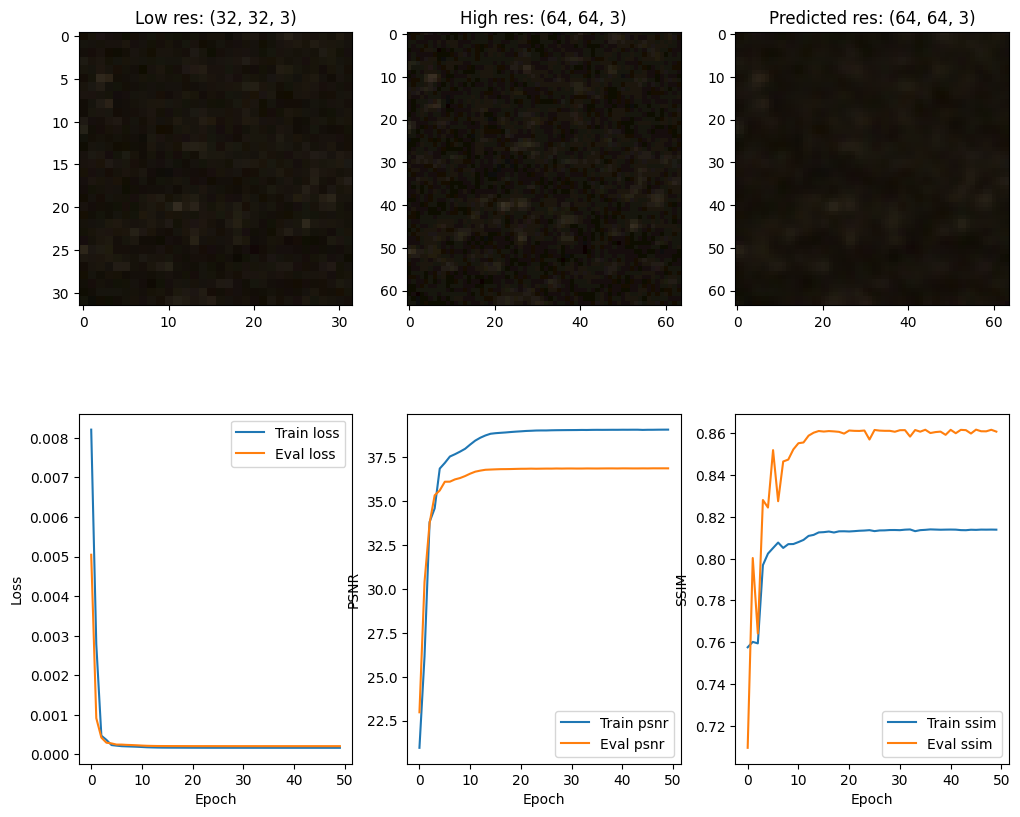

In [10]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 10))
exp.run(num_epochs=50, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, small_valid_dataset, np.random.randint(len(small_valid_dataset))))

In [11]:
# Show three images for a set and predict it
def plot_images_from_model(model, dataset, num_images=1, indices=None):
    images = []

    num_images = max(num_images, len(indices) if indices else 0)

    _, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    print(num_images)

    for i in range(num_images):
        if indices:
            low_res, high_res = dataset[indices[i]]
            print("Chosen index", indices[i])
        else:
            index = np.random.randint(len(dataset))
            low_res, high_res = dataset[index]
            print("Chosen index", index)

        images.append(low_res)
        images.append(high_res)

        with torch.no_grad():
            predicted_res = model.net(low_res.to(device))[0]

        images.append(predicted_res)

        low_res_image = torchUtil.tensor_to_image(low_res)
        high_res_image = torchUtil.tensor_to_image(high_res)
        predicted_res_image = torchUtil.tensor_to_image(predicted_res)

        axes[i, 0].set_title(f'Low res: {low_res_image.shape}')
        axes[i, 1].set_title(f'High res: {high_res_image.shape}')
        axes[i, 2].set_title(f'Predicted res: {predicted_res_image.shape}')

        axes[i, 0].imshow(low_res_image)
        axes[i, 1].imshow(high_res_image)
        axes[i, 2].imshow(predicted_res_image)
    
    plt.show()


3
Chosen index 0
Chosen index 1
Chosen index 2


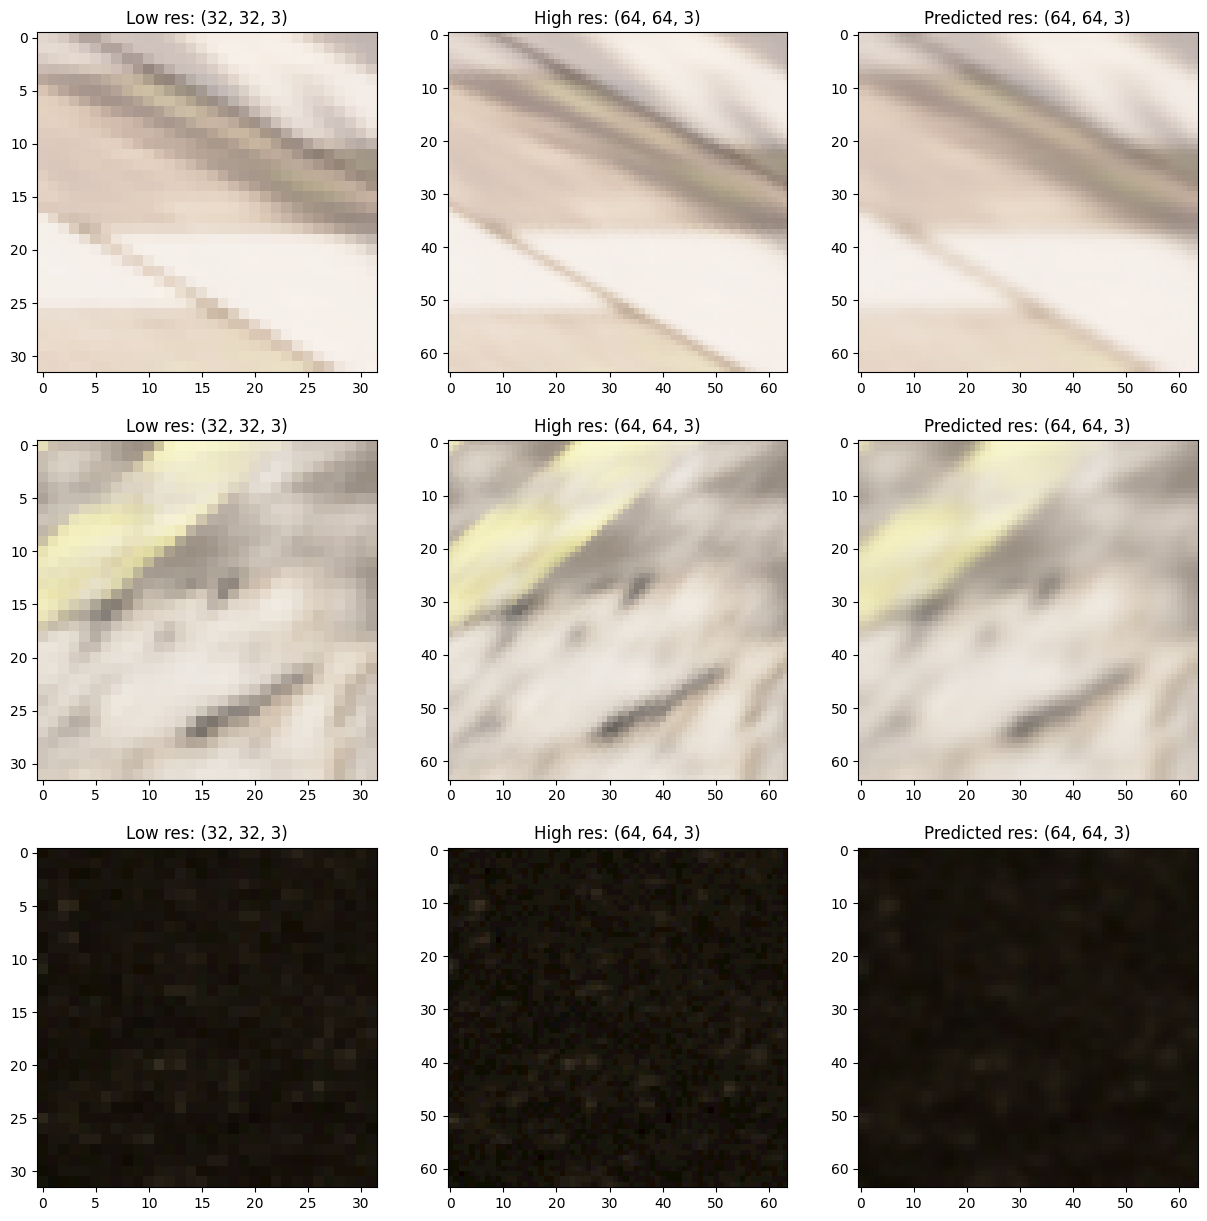

In [12]:
plot_images_from_model(exp, small_dataset, indices=[0, 1, 2])

# Training a model on a subsequent part of the original dataset

In [13]:

# Take the sub part of the dataset from random indices
train_size = int(0.8 * len(train_dataset_patched))
valid_size = len(train_dataset_patched) - train_size

train_sub_dataset, valid_sub_dataset = torch.utils.data.random_split(train_dataset_patched, [train_size, valid_size])

print("Size of train_dataset: ", len(train_sub_dataset))
print("Size of valid_dataset: ", len(valid_sub_dataset))

Size of train_dataset:  3200
Size of valid_dataset:  800


In [14]:
lr = 1e-3
batch_size = 512

torch.cuda.empty_cache()
r = UpscaleNN()
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
path = "results/superresol-upscale2"
exp1 = nt.Experiment(r, train_sub_dataset, valid_sub_dataset, adam, stats_manager, device, criterion, batch_size=batch_size,
                     output_dir=path, perform_validation_during_training=True)

Start/Continue training from epoch 50
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
Finish training for 20 epochs


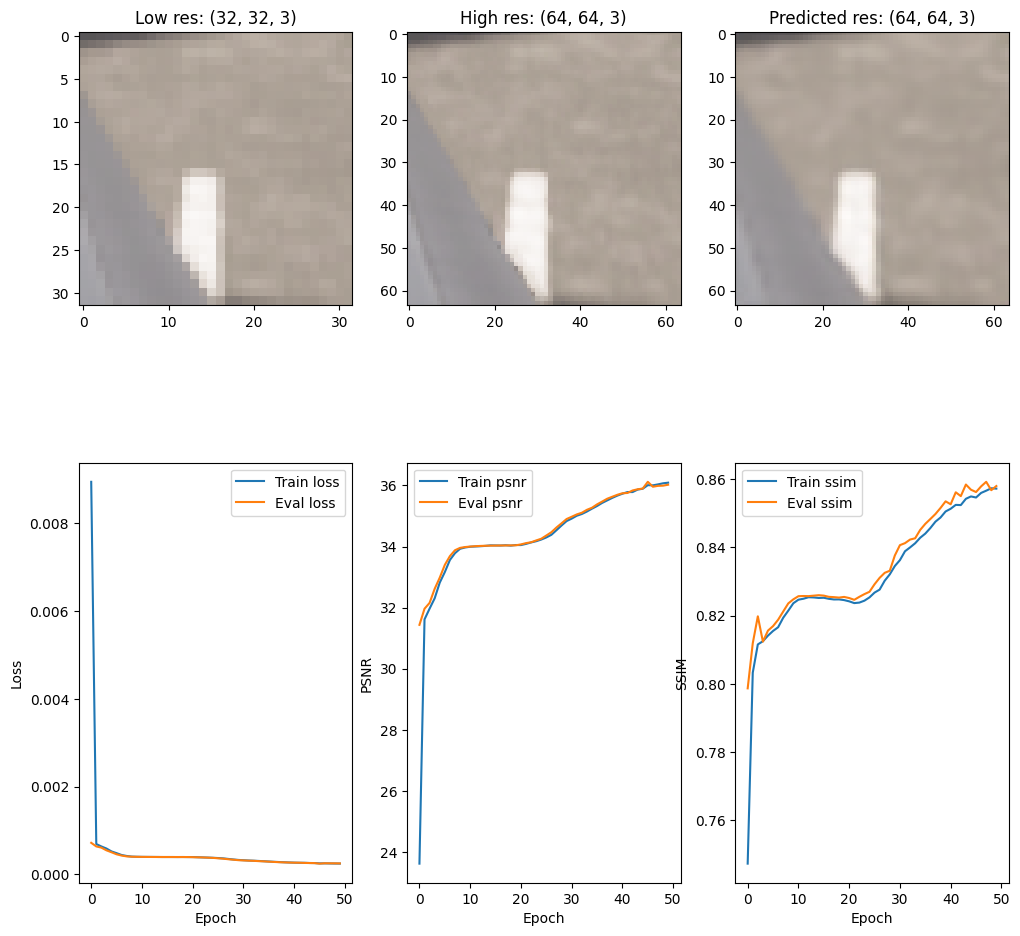

In [15]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
exp1.run(num_epochs=20, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, test_dataset_patched, np.random.randint(len(test_dataset_patched))))
#exp1.run(num_epochs=3, plot=None)

4
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
Chosen index 795
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
Chosen index 543
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
Chosen index 99
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
Chosen index 334


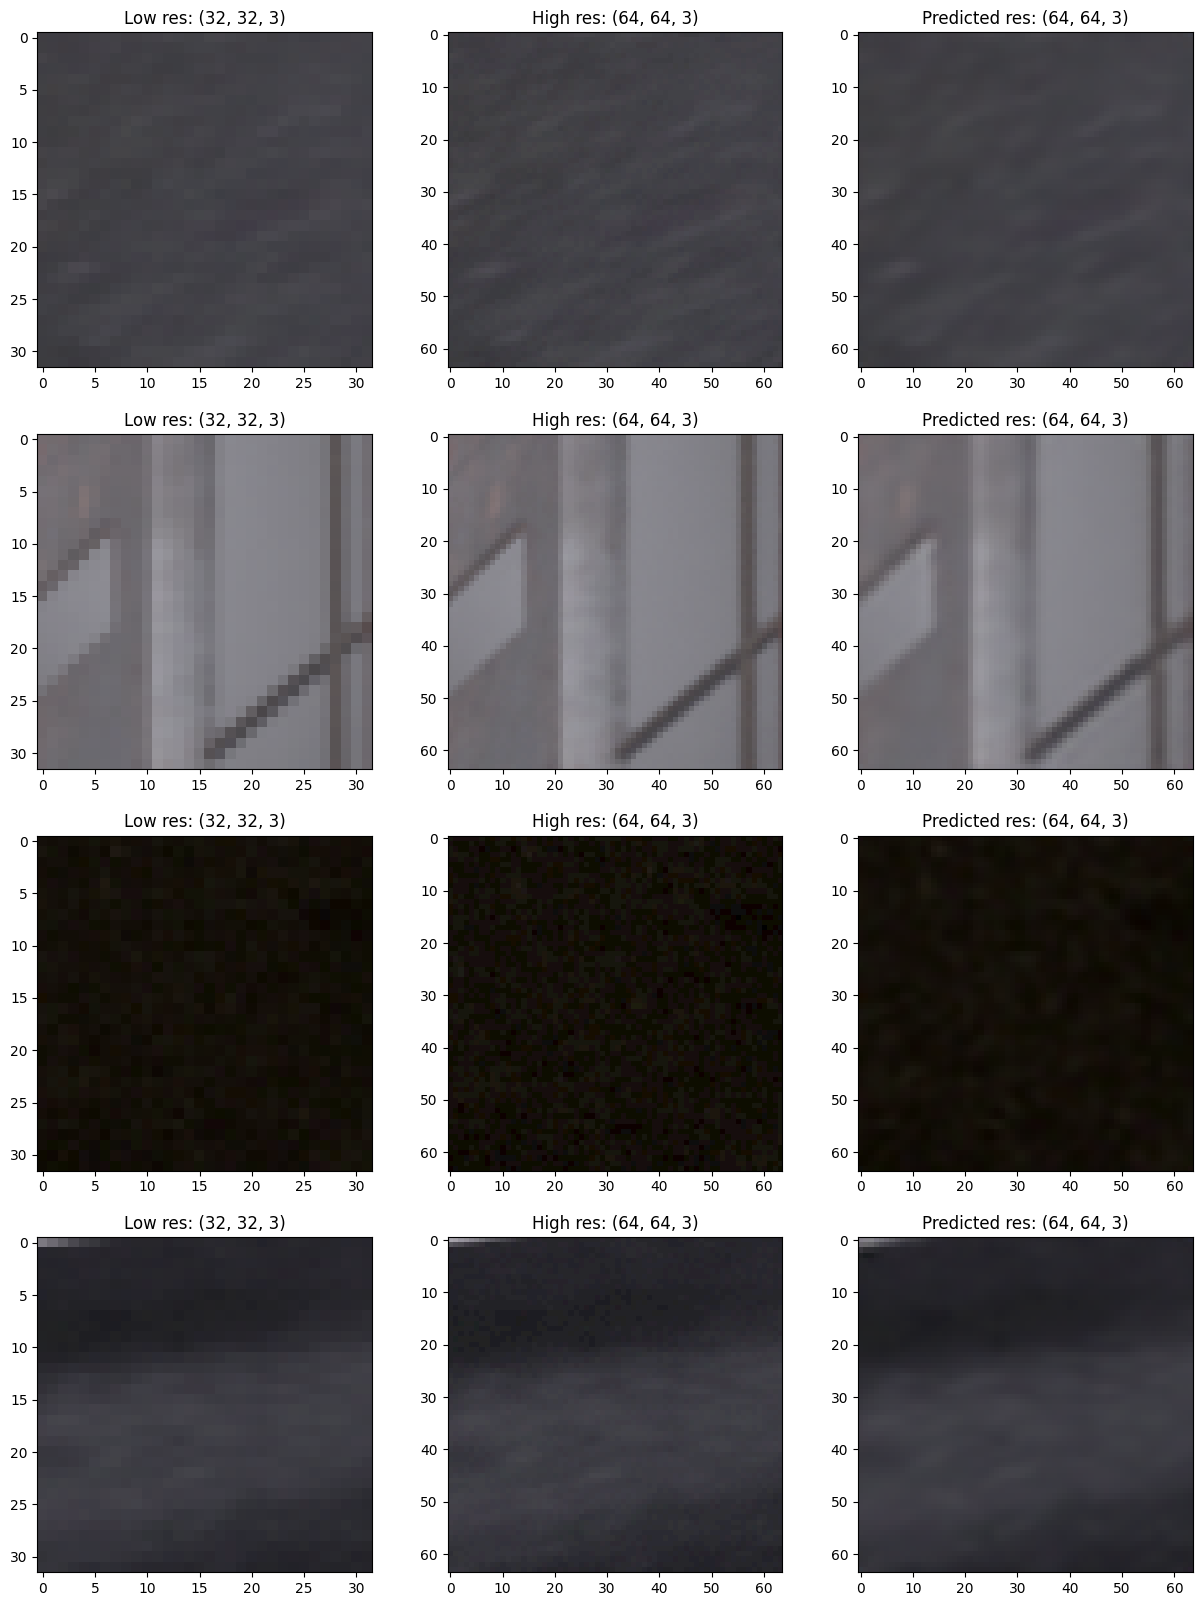

In [16]:
plot_images_from_model(exp1, test_dataset_patched, num_images=4)

4
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
Chosen index 469
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
Chosen index 569
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
Chosen index 152
torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
Chosen index 732


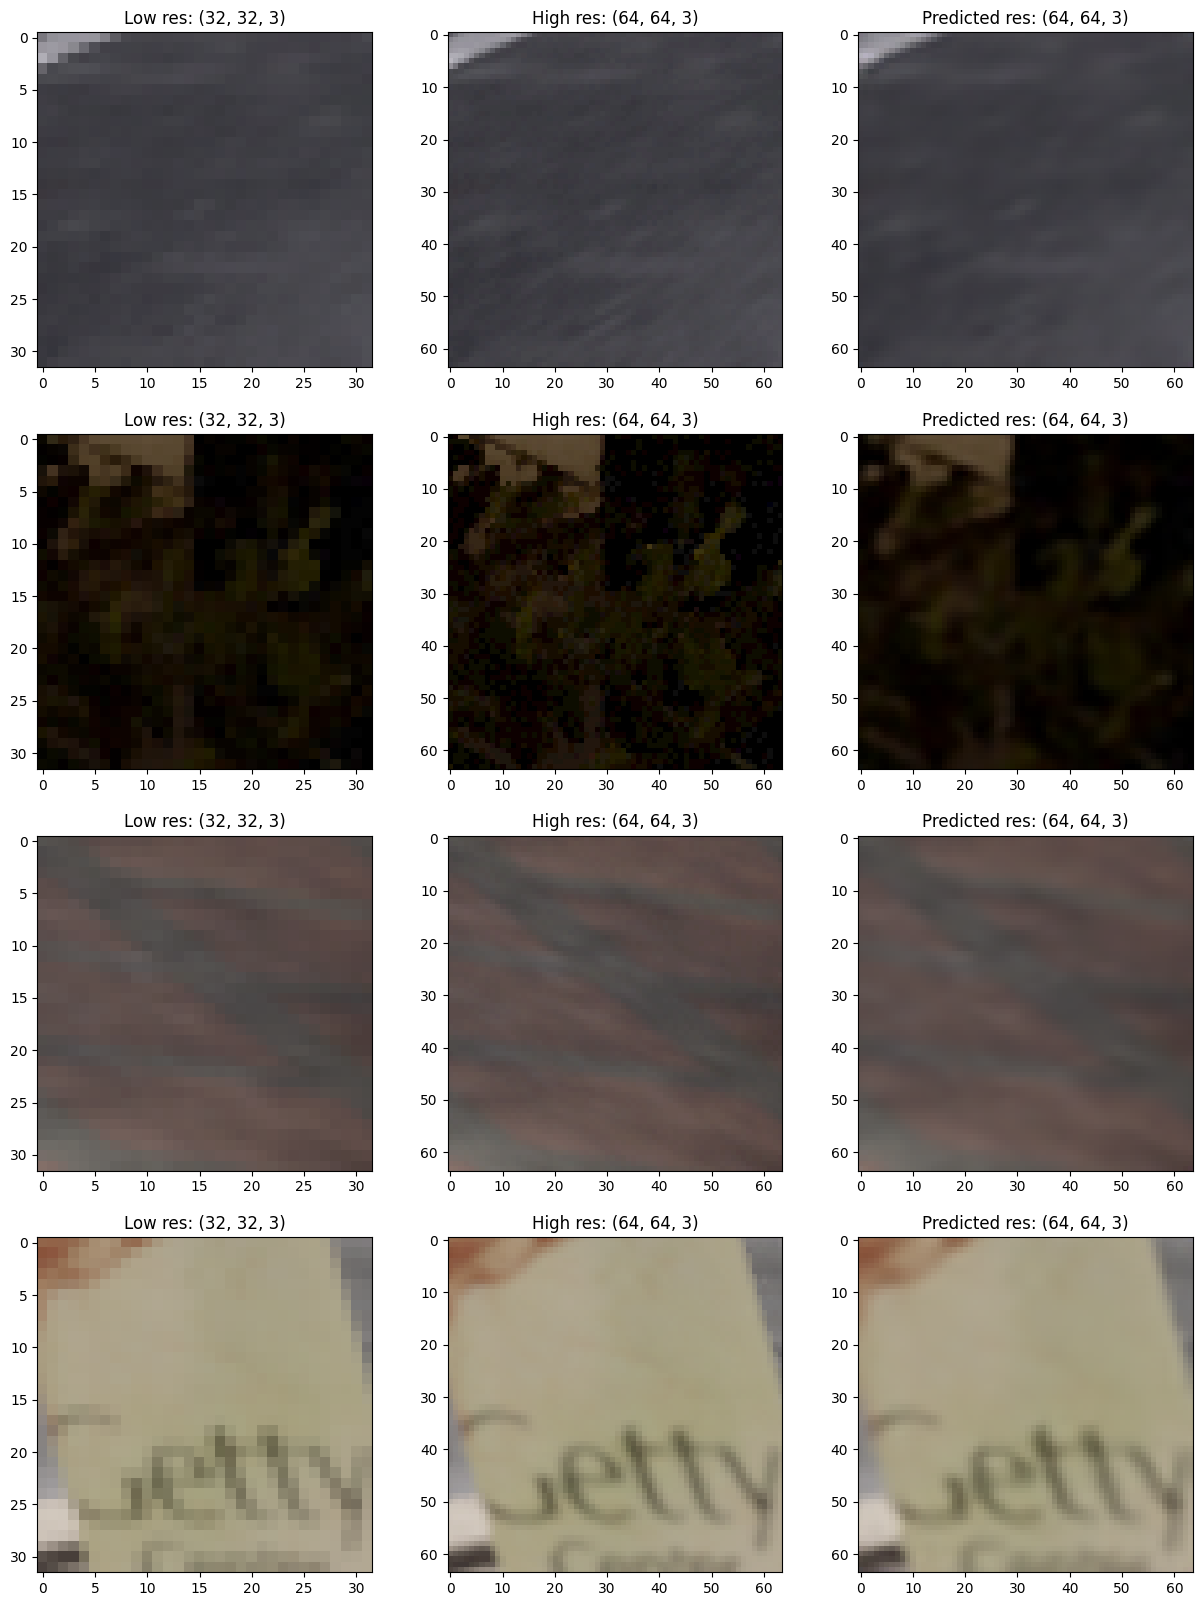

In [17]:
plot_images_from_model(exp1, test_dataset_patched, num_images=4)

# Reconstruct image from patch

In [18]:
from src.PatchImageTool import PatchImageTool

index_patch_train = np.random.randint(len(full_train_dataset))
index_patch_test = np.random.randint(len(full_test_dataset))

print("Choose index train", index_patch_train, "Choose index test", index_patch_test)

start_index_patch_train = full_train_dataset.get_index_start_patch(index_patch_train)
start_index_patch_test = full_test_dataset.get_index_start_patch(index_patch_test)

print ("Start index patch train", start_index_patch_train, "Start index patch test", start_index_patch_test)

index_train = full_train_dataset.get_index_for_image(index_patch_train)
index_test = full_test_dataset.get_index_for_image(index_patch_test)

print ("Index train", index_train, "Index test", index_test)

train_low_res, train_high_res = full_train_dataset.get_full_image(index_train)
test_low_res, test_high_res = full_test_dataset.get_full_image(index_test)

pred_high_res1 = PatchImageTool.predict_image_from_dataset_patches(exp1, (1920, 1080), full_train_dataset, index_patch_train, device)
pred_high_res2 = PatchImageTool.predict_image_from_dataset_patches(exp1, (1920, 1080), full_test_dataset, index_patch_test, device)

Choose index train 56014 Choose index test 90981
Start index patch train 55590 Start index patch test 90780
Index train 109 Index test 178


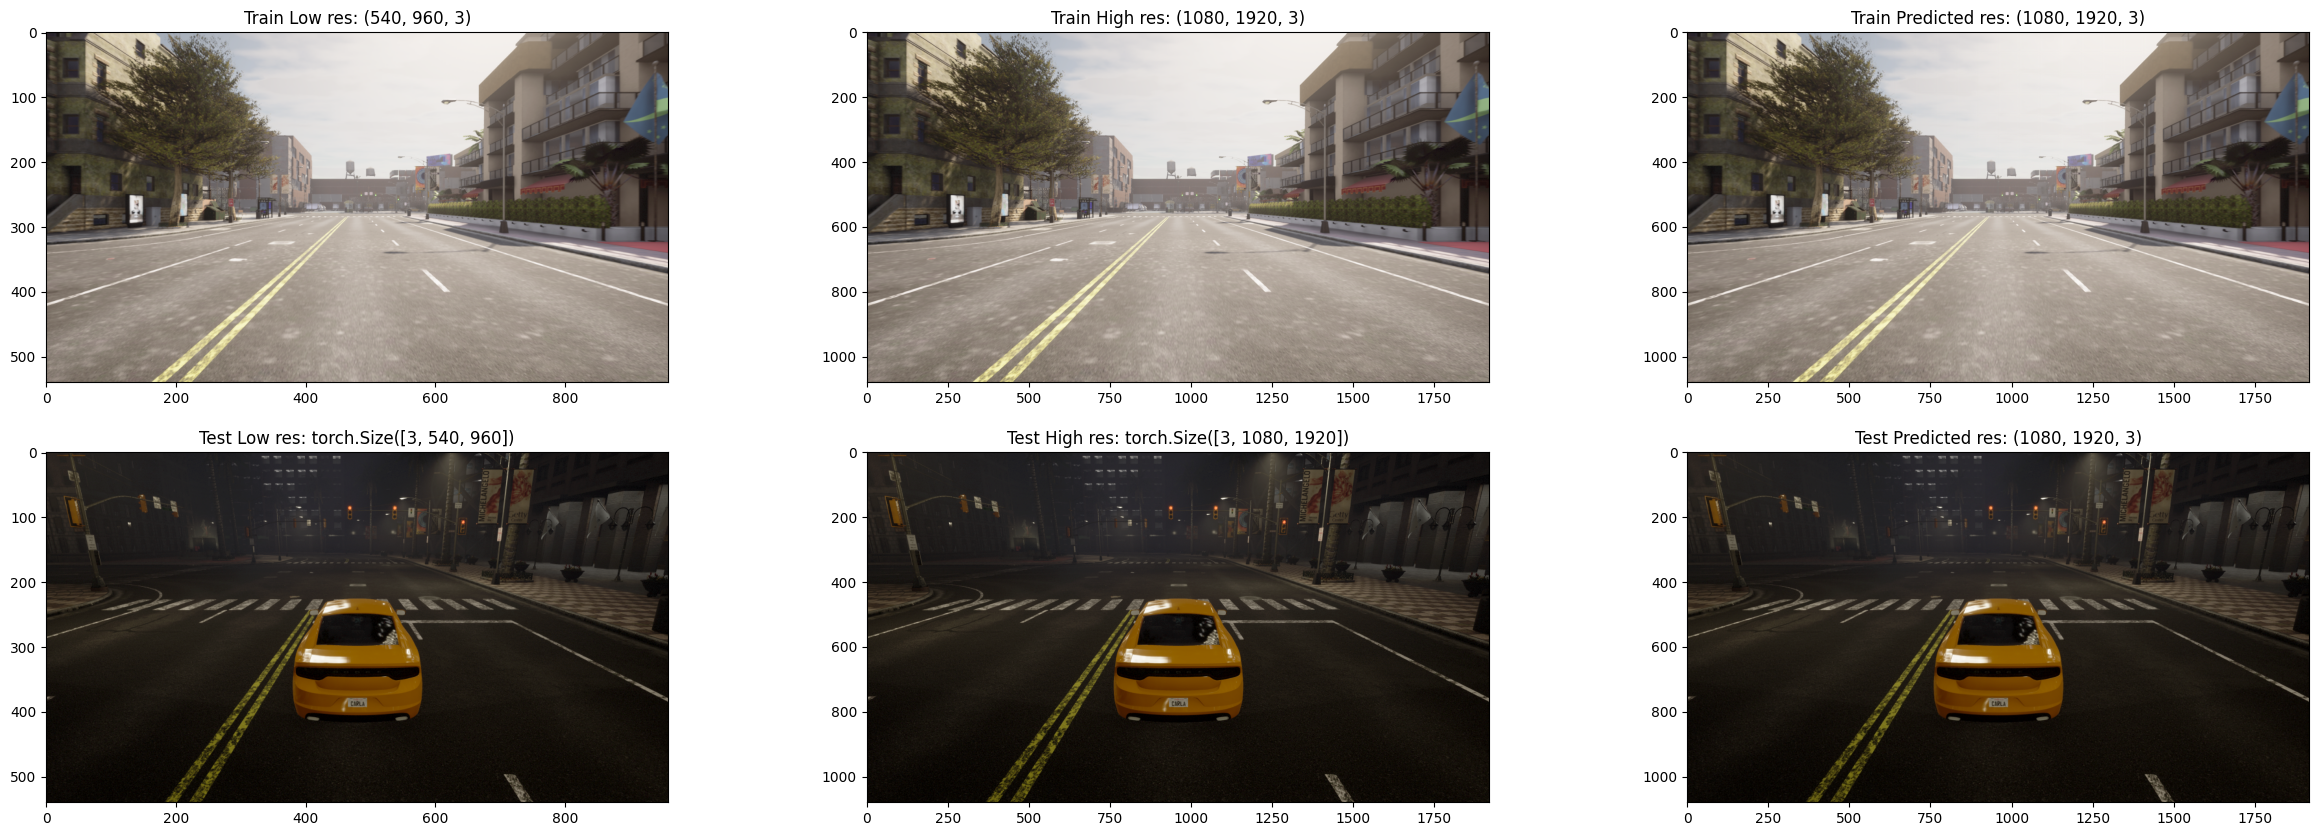

In [19]:
## Test on one image from the train and test set

fig, axes = plt.subplots(2, 3, figsize=(30, 10))

train_low_res_image = torchUtil.tensor_to_image(train_low_res)
train_high_res_image = torchUtil.tensor_to_image(train_high_res)
pred_high_res1_image = torchUtil.tensor_to_image(pred_high_res1)

axes[0][0].set_title(f'Train Low res: {train_low_res_image.shape}')
axes[0][1].set_title(f'Train High res: {train_high_res_image.shape}')
axes[0][2].set_title(f'Train Predicted res: {pred_high_res1_image.shape}')

axes[0][0].imshow(train_low_res_image)
axes[0][1].imshow(train_high_res_image)
axes[0][2].imshow(pred_high_res1_image)

test_low_res_image = torchUtil.tensor_to_image(test_low_res)
test_high_res_image = torchUtil.tensor_to_image(test_high_res)
pred_high_res2_image = torchUtil.tensor_to_image(pred_high_res2)

axes[1][0].set_title(f'Test Low res: {test_low_res.shape}')
axes[1][1].set_title(f'Test High res: {test_high_res.shape}')
axes[1][2].set_title(f'Test Predicted res: {pred_high_res2_image.shape}')

axes[1][0].imshow(test_low_res_image)
axes[1][1].imshow(test_high_res_image)
axes[1][2].imshow(pred_high_res2_image)

plt.show()

In [20]:
# Compute the PSNR and SSIM for the predicted image

train_high_res_np = torchUtil.tensor_to_numpy(train_high_res)
test_high_res_np = torchUtil.tensor_to_numpy(test_high_res)

pred_high_res1_np = torchUtil.tensor_to_numpy(pred_high_res1)
pred_high_res2_np = torchUtil.tensor_to_numpy(pred_high_res2)

print("PSNR for train image", metrics.peak_signal_noise_ratio(train_high_res_np, pred_high_res1_np))
print("SSIM for train image", metrics.structural_similarity(train_high_res_np, pred_high_res1_np, win_size=7, 
                                                            data_range=1, multichannel=True, channel_axis=2))

print("PSNR for test image", metrics.peak_signal_noise_ratio(test_high_res_np, pred_high_res2_np))
print("SSIM for test image", metrics.structural_similarity(test_high_res_np, pred_high_res2_np, win_size=7, 
                                                           data_range=1, multichannel=True, channel_axis=2))

PSNR for train image 40.26106355730591
SSIM for train image 0.9757314
PSNR for test image 36.39269476454784
SSIM for test image 0.87912726


In [21]:
sub_dataset_size = 10

# Compute the PSNR and SSIM for the predicted image on a subset of the train set
train_psnr, train_ssim = PatchImageTool.compute_metrics_dataset(exp1, full_train_dataset, sub_dataset_size, (1920, 1080), device)

# Compute the PSNR and SSIM for the predicted image on a subset of the test set
test_psnr, test_ssim = PatchImageTool.compute_metrics_dataset(exp1, full_test_dataset, sub_dataset_size, (1920, 1080), device)

print()
print("PSNR scores for test images, mean : ", test_psnr.mean(), ", var :", test_psnr.var())
print("Average SSIM for test images, mean : ", test_ssim.mean(), ", var :", test_ssim.var())

print("Average PSNR for train images, mean : ", train_psnr.mean(), ", var :", train_psnr.var())
print("Average SSIM for train images, mean : ", train_ssim.mean(), ", var :", train_ssim.var())

Current index 0 PSNR 35.823352078128906 SSIM 0.8590132594108582
Current index 1 PSNR 35.18651466881781 SSIM 0.9446205496788025
Current index 2 PSNR 39.34206483368391 SSIM 0.962222158908844
Current index 3 PSNR 39.77490666459862 SSIM 0.9719001650810242
Current index 4 PSNR 40.15465618086341 SSIM 0.9791243076324463
Current index 5 PSNR 40.20318551568156 SSIM 0.970048189163208
Current index 6 PSNR 39.50234880895232 SSIM 0.9687995314598083
Current index 7 PSNR 38.07760350671489 SSIM 0.9388214945793152
Current index 8 PSNR 35.87963706865806 SSIM 0.9511445164680481
Current index 9 PSNR 40.50324010475541 SSIM 0.9750165343284607
Current index 0 PSNR 35.92610904605175 SSIM 0.9508635401725769
Current index 1 PSNR 38.11130402227743 SSIM 0.902350127696991
Current index 2 PSNR 36.34355345880509 SSIM 0.9550173878669739
Current index 3 PSNR 34.76362803619481 SSIM 0.8557987213134766
Current index 4 PSNR 34.18821822664782 SSIM 0.8997041583061218
Current index 5 PSNR 36.38532040027475 SSIM 0.88316780328

In [22]:
# Test on 20 images from the test set
sub_dataset_size = 20
indices = np.random.choice(len(full_test_dataset), sub_dataset_size, replace=False)
predicted_images = PatchImageTool.predict_images_from_dataset_patches(exp1, (1920, 1080), full_test_dataset, indices, device)

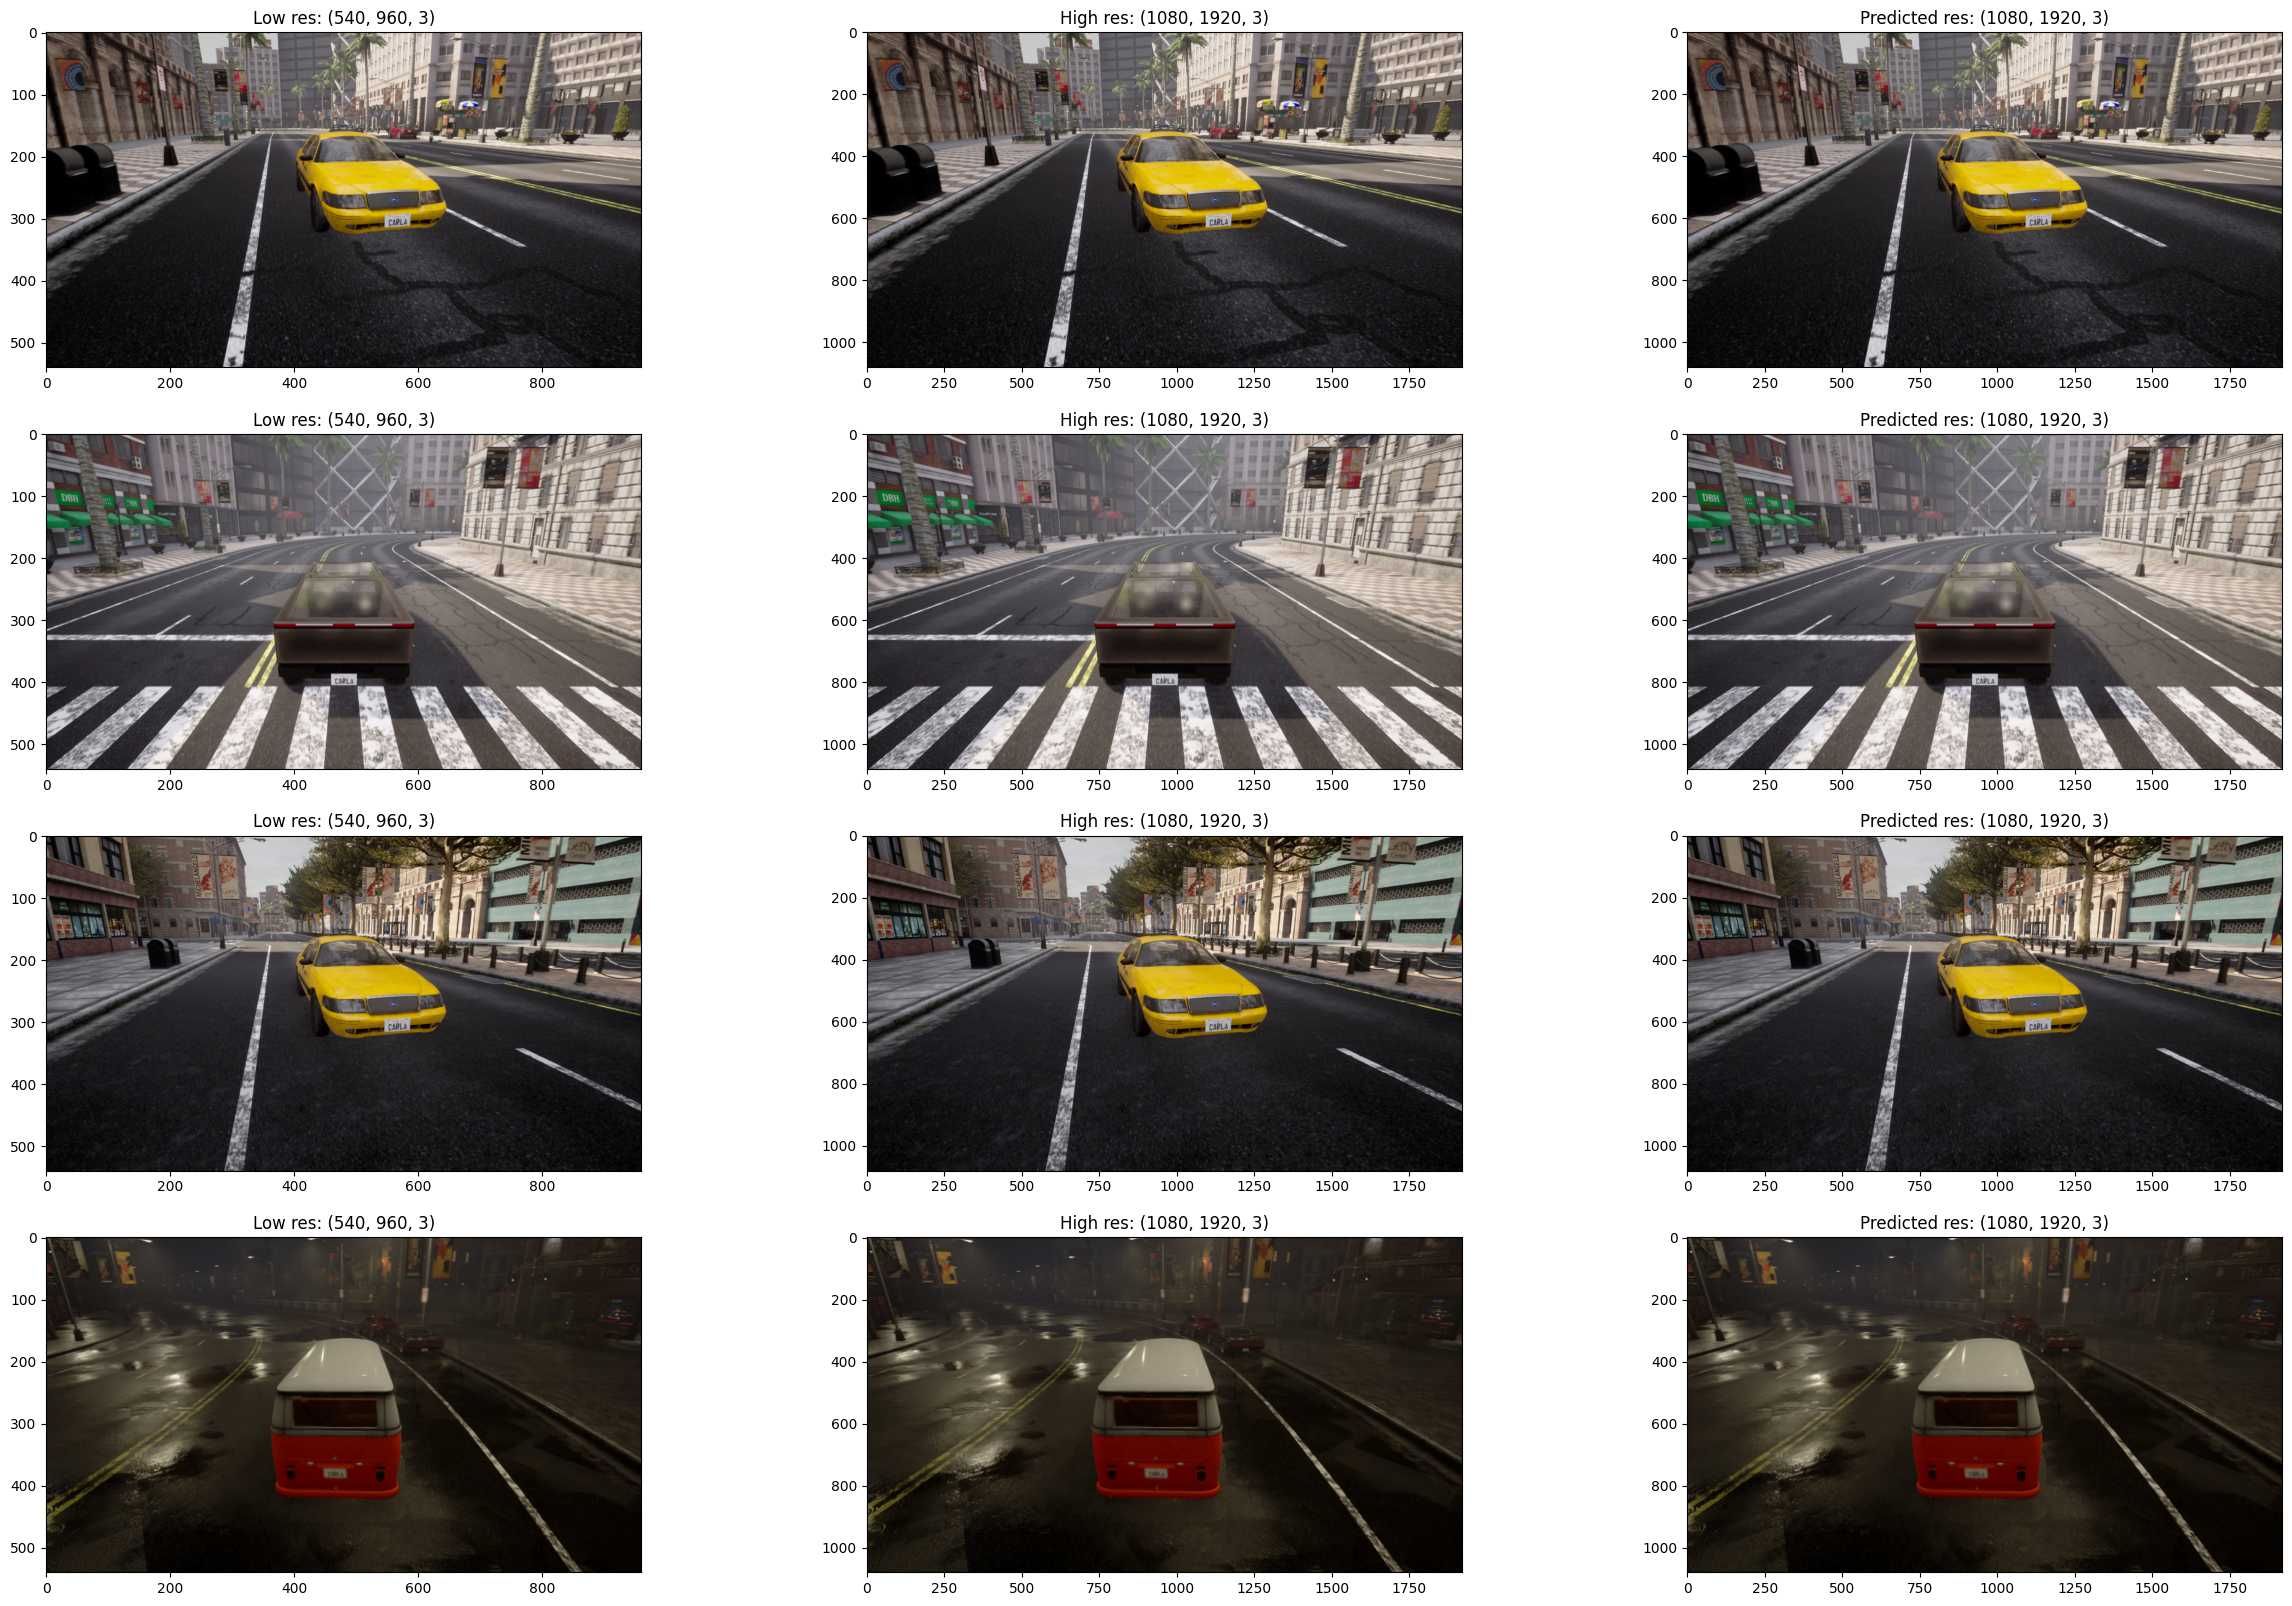

In [23]:
# Show 4 images, real vs predicted

fig, axes = plt.subplots(4, 3, figsize=(30, 20))

for i in range(4):
    index = indices[i]
    image_index = full_test_dataset.get_index_for_image(index)

    low_res, high_res = full_test_dataset.get_full_image(image_index)

    low_res_image = torchUtil.tensor_to_image(low_res)
    high_res_image = torchUtil.tensor_to_image(high_res)
    pred_high_res_image = torchUtil.tensor_to_image(predicted_images[i])
    
    axes[i][0].set_title(f'Low res: {low_res_image.shape}')
    axes[i][1].set_title(f'High res: {high_res_image.shape}')
    axes[i][2].set_title(f'Predicted res: {pred_high_res_image.shape}')

    axes[i][0].imshow(low_res_image)
    axes[i][1].imshow(high_res_image)
    axes[i][2].imshow(pred_high_res_image)

plt.show()

In [24]:
# compute the mean and var psnr and ssim for 100 images from the test set

batch_size = full_test_dataset.get_number_patch_per_image() * 4

sub_dataset_size = len(full_test_dataset) // full_test_dataset.get_number_patch_per_image()
print("Number of images in full data set part", sub_dataset_size)
test_psnr, test_ssim = PatchImageTool.compute_metrics_dataset_batched(exp1, (1920, 1080), full_test_dataset, sub_dataset_size, device, batch_size)

# compute the mean and var psnr and ssim for 100 images from the train set

sub_dataset_size = len(full_train_dataset) // full_train_dataset.get_number_patch_per_image() 
print("Number of images in full data set part", sub_dataset_size)
train_psnr, train_ssim = PatchImageTool.compute_metrics_dataset_batched(exp1,  (1920, 1080), full_train_dataset, sub_dataset_size, device, batch_size)


print("Average PSNR for test images", test_psnr.mean(), "Variance", test_psnr.var())
print("Average SSIM for test images", test_ssim.mean(), "Variance", test_ssim.var())

print("Average PSNR for train images", train_psnr.mean(), "Variance", train_psnr.var())
print("Average SSIM for train images", train_ssim.mean(), "Variance", train_ssim.var())


Number of images in full data set part 200
Number of images in full data set part 800
Average PSNR for test images 36.920678541839564 Variance 8.174568394986757
Average SSIM for test images 0.9319740444421768 Variance 0.001634399171289287
Average PSNR for train images 37.216733704866385 Variance 8.076378384944267
Average SSIM for train images 0.9359021432697773 Variance 0.0015219547477824053
